# WLS-EV Analysis

In [1]:
"""
KIT CRAM Seminar WS17/18
Algorithmic Design - Least squares estimates weighted by ex-ante return variance (WLS-EV)
"""

__author__ = 'Tobias Kuhlmann'

# Import own libraries
from variance_estimation import ExAnteVariance
from wlsev_model import Wlsev_model
from ols_model import OLS_model
import visualisation
from simon_ols_model import OLS
# import general packages
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline


/Users/tobias/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Preprocessing

### Read in log return data and variance

### Log returns

In [2]:
# Import price data and calc log returns
# --------------------------------------------------
es_50_prices = pd.read_csv('data/eurostoxx50_prices_eod.csv', parse_dates=True)
# set index, rename and check
es_50_prices['loctimestamp'] =pd.to_datetime(es_50_prices['loctimestamp'])
es_50_prices = es_50_prices.rename(columns={'loctimestamp': 'date'})
es_50_prices = es_50_prices.set_index('date')

#Log Returns
es_50_logret = es_50_prices
es_50_logret['logreturns'] = (np.log(es_50_prices['lastprice'] / es_50_prices['lastprice'].shift(1))).dropna()

del es_50_logret['lastprice']

### Volatility data

In [3]:
# Import vol data
# --------------------------------------------------
es_50_vol = pd.read_csv('data/es50_volatility.csv', parse_dates=True)
# Transform dates
es_50_vol['loctimestamp'] = pd.to_datetime(es_50_vol['loctimestamp'])
# Delete unnecessary columns
del es_50_vol['instrumentid']
# Calculate variance from vol
es_50_vol['variance'] = es_50_vol['volatility'] ** 2
del es_50_vol['volatility']
# set index, rename and check
es_50_vol = es_50_vol.rename(columns={'loctimestamp': 'date'})
es_50_vol = es_50_vol.set_index('date')

### Implied volatility data 

In [4]:
# Import implied volatility
# --------------------------------------------------
es_50_imp_vol = pd.read_csv('data/es50_implied_volatility.csv', parse_dates=True)
# Transform dates
es_50_imp_vol['loctimestamp'] = pd.to_datetime(es_50_imp_vol['loctimestamp'])
# Delete unnecessary columns
del es_50_imp_vol['instrumentid']
del es_50_imp_vol['maturity']
# Calculate implied variance from implied vol
es_50_imp_vol['implied_var'] = es_50_imp_vol['measure'] ** 2
del es_50_imp_vol['measure']
# set index, rename and check
es_50_imp_vol = es_50_imp_vol.rename(columns={'loctimestamp': 'date'})
es_50_imp_vol = es_50_imp_vol.set_index('date')

### Riskfree rate

In [5]:
# Import riskfree rate data
# --------------------------------------------------
rf = pd.read_csv('data/riskfree_rate.csv', parse_dates=True, sep=';')
# Transform dates
rf['loctimestamp'] = pd.to_datetime(rf['loctimestamp'])
# set index, rename and check
rf = rf.rename(columns={'loctimestamp': 'date'})
rf = rf.set_index('date')

### VRP data

In [6]:
# Import VRP data
# --------------------------------------------------
es_50_vrp = pd.read_csv('data/es50_vrp.csv', parse_dates=True)
# Transform dates
es_50_vrp['loctimestamp'] = pd.to_datetime(es_50_vrp['loctimestamp'])
# set index, rename and check
es_50_vrp = es_50_vrp.rename(columns={'loctimestamp': 'date'})
es_50_vrp = es_50_vrp.set_index('date')

### ERP data

In [7]:
# Calculate ERP from logrets and riskfree rate
# Take risk free rate maturity 7 (smallest maturity)
rf_mat7 = rf[rf['daystomaturity'] == 7].shift(-1) / 252
# Calculate ERP = logrets - rf
es_50_erp = pd.DataFrame({'erp': (es_50_logret['logreturns'] - rf_mat7['riskfree']).dropna()})

### Q-Moments data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c0ad60b70>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1040bdc88>], dtype=object)

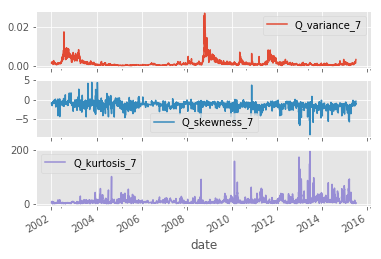

In [8]:
# Import Q-Moments data
# --------------------------------------------------
es_50_q = pd.read_csv('data/FiglewskiStandardizationEOD_DE0009652396D1_Qmoments.csv', parse_dates=True, sep = ';')
es_50_q.head(5)
# Transform dates
es_50_q['loctimestamp'] = pd.to_datetime(es_50_q['loctimestamp'])
# set index, rename and check
es_50_q = es_50_q.rename(columns={'loctimestamp': 'date'})
es_50_q = es_50_q.set_index('date')

# Delete unnecessary columns
del es_50_q['underlyingprice']
del es_50_q['underlyingforwardprice']
del es_50_q['Q_cubic']
del es_50_q['Q_quartic']

# Split maturities into seperate columns
es_50_q_7 = es_50_q[es_50_q['daystomaturity'] == 7]
es_50_q_7 = es_50_q_7.rename(columns={'Q_variance': 'Q_variance_7', 'Q_skewness': 'Q_skewness_7', 'Q_kurtosis': 'Q_kurtosis_7'})
del es_50_q_7['daystomaturity']

es_50_q_30 = es_50_q[es_50_q['daystomaturity'] == 30]
es_50_q_30 = es_50_q_30.rename(columns={'Q_variance': 'Q_variance_30', 'Q_skewness': 'Q_skewness_30', 'Q_kurtosis': 'Q_kurtosis_30'})
del es_50_q_30['daystomaturity']

es_50_q_60 = es_50_q[es_50_q['daystomaturity'] == 60]
es_50_q_60 = es_50_q_60.rename(columns={'Q_variance': 'Q_variance_60', 'Q_skewness': 'Q_skewness_60', 'Q_kurtosis': 'Q_kurtosis_60'})
del es_50_q_60['daystomaturity']

es_50_q_91 = es_50_q[es_50_q['daystomaturity'] == 91]
es_50_q_91 = es_50_q_91.rename(columns={'Q_variance': 'Q_variance_91', 'Q_skewness': 'Q_skewness_91', 'Q_kurtosis': 'Q_kurtosis_91'})
del es_50_q_91['daystomaturity']

es_50_q_182 = es_50_q[es_50_q['daystomaturity'] == 182]
es_50_q_182 = es_50_q_182.rename(columns={'Q_variance': 'Q_variance_182', 'Q_skewness': 'Q_skewness_182', 'Q_kurtosis': 'Q_kurtosis_182'})
del es_50_q_182['daystomaturity']

es_50_q_365 = es_50_q[es_50_q['daystomaturity'] == 365]
es_50_q_365 = es_50_q_365.rename(columns={'Q_variance': 'Q_variance_365', 'Q_skewness': 'Q_skewness_365', 'Q_kurtosis': 'Q_kurtosis_365'})
del es_50_q_365['daystomaturity']

es_50_q_7.plot(subplots = True)

### P-Moments data

In [9]:
# Import 5 min price data and calc log returns
# --------------------------------------------------
es_50_prices_5 = pd.read_csv('data/eurostoxx50_prices_5m.csv', parse_dates=True, sep=';')
# set index, rename and check
es_50_prices_5 = es_50_prices_5.rename(columns={'loctimestamp': 'date'})
es_50_prices_5['date'] = pd.to_datetime(es_50_prices_5['date'], errors='coerce')
es_50_prices_5 = es_50_prices_5.set_index('date')

#Log Returns
es_50_logret_5 = es_50_prices_5
es_50_logret_5['logreturns5min'] = np.log(es_50_prices_5['price'] / es_50_prices_5['price'].shift(1))
es_50_logret_5 = es_50_logret_5.dropna()

# Count of values per day
N = (es_50_logret_5.loc[(es_50_logret_5.index >= '2004-07-04 00:00:00') & (es_50_logret_5.index <= '2004-07-06 00:00:00')]).shape[0]

# Calculate moments after Amaya, Christoffersen, Jacobs, Vasquez (2015) - Does realized skewness predict equity returns
es_50_logret_5['logreturns_pow2'] = es_50_logret_5['logreturns5min'] ** 2
es_50_logret_5['logreturns_pow3'] = es_50_logret_5['logreturns5min'] ** 3
es_50_logret_5['logreturns_pow4'] = es_50_logret_5['logreturns5min'] ** 4

# group by date and sum up
helper = es_50_logret_5.groupby(es_50_logret_5.index.date).sum()

# Var 1 day = sum of intraday squared returns
es_50_P_1 = pd.DataFrame({'var1': helper['logreturns_pow2']})
# Skewness 1 day
es_50_P_1['skewness1'] = ( np.sqrt(N) * helper['logreturns_pow3']) / (es_50_P_1['var1'] ** (3 / 2) )
# Kurtosis 1 day
es_50_P_1['kurtosis1'] = N * helper['logreturns_pow4'] / (es_50_P_1['var1'] ** 2)


# Var 7 days ahead = sum of intraday squared returns
es_50_P_7 = pd.DataFrame({'var7': helper['logreturns_pow2'].rolling(7).sum().shift(-6)})
# Skewness and its variance 7 days
es_50_P_7['skewness7'] = (np.sqrt(N * 7) * helper['logreturns_pow3'].rolling(7).sum().shift(-6)) / (es_50_P_7['var7'] ** (3 / 2) )
es_50_P_7['var_skewness7'] = (es_50_P_1['skewness1'] ** 2).rolling(7).sum().shift(-6)
# Kurtosis and its variance 7 days
es_50_P_7['kurtosis7'] = (N* 7 * helper['logreturns_pow4'].rolling(7).sum().shift(-6)) / (es_50_P_7['var7'] ** 2)
es_50_P_7['var_kurtosis7'] = (es_50_P_1['kurtosis1'] ** 2).rolling(7).sum().shift(-6)

# Var 30 days ahead = sum of intraday squared returns
es_50_P_30 = pd.DataFrame({'var30': helper['logreturns_pow2'].rolling(30).sum().shift(-29)})
# Skewness and its variance 30 days
es_50_P_30['skewness30'] = (np.sqrt(N * 30) * helper['logreturns_pow3'].rolling(30).sum().shift(-29)) / (es_50_P_30['var30'] ** (3 / 2) )
es_50_P_30['var_skewness30'] = (es_50_P_1['skewness1'] ** 2).rolling(30).sum().shift(-29)
# Kurtosis and its variance 30 days
es_50_P_30['kurtosis30'] = (N * 30 * helper['logreturns_pow4'].rolling(30).sum().shift(-29)) / (es_50_P_30['var30'] ** 2)
es_50_P_30['var_kurtosis30'] = (es_50_P_1['kurtosis1'] ** 2).rolling(30).sum().shift(-29)

# Var 60 days ahead = sum of intraday squared returns
es_50_P_60 = pd.DataFrame({'var60': helper['logreturns_pow2'].rolling(60).sum().shift(-59)})
# Skewness and its variance 60 days
es_50_P_60['skewness60'] = (np.sqrt(N * 60) * helper['logreturns_pow3'].rolling(60).sum().shift(-59)) / (es_50_P_60['var60'] ** (3 / 2) )
es_50_P_60['var_skewness60'] = (es_50_P_1['skewness1'] ** 2).rolling(60).sum().shift(-59)
# Kurtosis and its variance 60 days
es_50_P_60['kurtosis60'] = (N * 60 * helper['logreturns_pow4'].rolling(60).sum().shift(-59)) / (es_50_P_60['var60'] ** 2)
es_50_P_60['var_kurtosis60'] = (es_50_P_1['kurtosis1'] ** 2).rolling(60).sum().shift(-59)

# Var 91 days ahead = sum of intraday squared returns
es_50_P_91 = pd.DataFrame({'var91': helper['logreturns_pow2'].rolling(91).sum().shift(-90)})
# Skewness and its variance 91 days
es_50_P_91['skewness91'] = (np.sqrt(N * 91) * helper['logreturns_pow3'].rolling(60).sum().shift(-90)) / (es_50_P_91['var91'] ** (3 / 2) )
es_50_P_91['var_skewness91'] = (es_50_P_1['skewness1'] ** 2).rolling(91).sum().shift(-90)
# Kurtosis and its variance 91 days
es_50_P_91['kurtosis91'] = (N * 91 * helper['logreturns_pow4'].rolling(91).sum().shift(-90)) / (es_50_P_91['var91'] ** 2)
es_50_P_91['var_kurtosis91'] = (es_50_P_1['kurtosis1'] ** 2).rolling(91).sum().shift(-90)

# Var 182 days ahead = sum of intraday squared returns
es_50_P_182 = pd.DataFrame({'var182': helper['logreturns_pow2'].rolling(182).sum().shift(-181)})
# Skewness and its variance 182 days
es_50_P_182['skewness182'] = (np.sqrt(N * 182) * helper['logreturns_pow3'].rolling(182).sum().shift(-181)) / (es_50_P_182['var182'] ** (3 / 2) )
es_50_P_182['var_skewness182'] = (es_50_P_1['skewness1'] ** 2).rolling(182).sum().shift(-181)
# Kurtosis and its variance 182 days
es_50_P_182['kurtosis182'] = (N * 182 * helper['logreturns_pow4'].rolling(182).sum().shift(-181)) / (es_50_P_182['var182'] ** 2)
es_50_P_182['var_kurtosis182'] = (es_50_P_1['kurtosis1'] ** 2).rolling(182).sum().shift(-181)

# Var 365 days ahead = sum of intraday squared returns
es_50_P_365 = pd.DataFrame({'var365': helper['logreturns_pow2'].rolling(365).sum().shift(-364)})
# Skewness and its variance 365 days
es_50_P_365['skewness365'] = (np.sqrt(N * 365) * helper['logreturns_pow3'].rolling(365).sum().shift(-364)) / (es_50_P_365['var365'] ** (3 / 2) )
es_50_P_365['var_skewness365'] = (es_50_P_1['skewness1'] ** 2).rolling(365).sum().shift(-364)
# Kurtosis and its variance 365 days
es_50_P_365['kurtosis365'] = (N * 365 * helper['logreturns_pow4'].rolling(365).sum().shift(-364)) / (es_50_P_365['var365'] ** 2)
es_50_P_365['var_kurtosis365'] = (es_50_P_1['kurtosis1'] ** 2).rolling(365).sum().shift(-364)

/Users/tobias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tobias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tobias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

### Fama-French data

In [10]:
# Import Fama French Factors
# --------------------------------------------------
# HML and SMB
es_50_ff = pd.read_csv('data/FamaFrench_Europe_3_Factors_Daily.csv', parse_dates=True, skiprows=6)
es_50_ff = es_50_ff.rename(columns={'Unnamed: 0': 'date'})
es_50_ff['date'] = pd.to_datetime(es_50_ff['date'], format = '%Y%m%d')
es_50_ff = es_50_ff.set_index('date')

# Momentum Factor
es_50_ff2 = pd.read_csv('data/FamaFrench_Europe_MOM_Factor_Daily.csv', parse_dates=True, skiprows=6)
es_50_ff2 = es_50_ff2.rename(columns={'Unnamed: 0': 'date'})
es_50_ff2['date'] = pd.to_datetime(es_50_ff2['date'], format = '%Y%m%d')
es_50_ff2 = es_50_ff2.set_index('date')

# Join and drop na's
es_50_ff = es_50_ff.join(es_50_ff2).dropna()



## Join data for correct dates

In [11]:
# Join data
data_all = pd.concat([es_50_logret, es_50_vol, es_50_imp_vol, es_50_vrp, es_50_erp, es_50_q_7, es_50_q_30, es_50_q_60, es_50_q_91, es_50_q_182, es_50_q_365, es_50_P_7, es_50_P_30, es_50_P_60, es_50_P_91, es_50_P_182, es_50_P_365, es_50_ff], join='inner', axis=1).dropna()
data_wop = pd.concat([es_50_logret, es_50_vol, es_50_imp_vol, es_50_vrp, es_50_erp, es_50_q_7, es_50_q_30, es_50_q_60, es_50_q_91, es_50_q_182, es_50_q_365, es_50_ff], join='inner', axis=1).dropna()
data_pq = pd.concat([es_50_q_7, es_50_q_30, es_50_q_60, es_50_q_91, es_50_q_182, es_50_q_365, es_50_P_7, es_50_P_30, es_50_P_60, es_50_P_91, es_50_P_182, es_50_P_365], join='inner', axis=1).dropna()

#data_wop.plot(subplots=True)
print(data_all.shape)
print(data_wop.shape)
print(data_pq.shape)

data_pq.head(100)

(0, 58)
(1947, 28)
(433, 48)


,Q_variance_7,Q_skewness_7,Q_kurtosis_7,Q_variance_30,Q_skewness_30,Q_kurtosis_30,Q_variance_60,Q_skewness_60,Q_kurtosis_60,Q_variance_91,...,var182,skewness182,var_skewness182,kurtosis182,var_kurtosis182,var365,skewness365,var_skewness365,kurtosis365,var_kurtosis365
2002-01-03,0.001399,-0.957280,6.30359,0.006565,-1.464300,7.29619,0.011637,-0.936477,3.162630,0.020744,...,0.069645,0.004819,946.605788,39.130333,58681.692441,0.160962,0.042798,1639.347028,28.355445,99544.648448
2002-01-04,0.001253,-1.213200,9.27311,0.006649,-2.040180,11.75240,0.011340,-0.821402,3.314860,0.019756,...,0.070367,0.004335,937.987814,38.449408,58470.231365,0.161036,0.040278,1631.471497,28.331822,99418.386333
2002-01-07,0.001576,-1.137360,8.28895,0.006559,-1.210230,5.66550,0.011694,-0.674078,2.916230,0.020660,...,0.071224,0.000669,937.986404,37.717431,58374.647588,0.161119,0.044642,1643.789209,28.325004,100134.193204
2002-01-08,0.001495,-1.085010,6.73585,0.006284,-1.227600,5.39427,0.011376,-0.663016,2.951790,0.020075,...,0.071758,-0.002327,937.897985,37.208778,58374.308129,0.161088,0.045177,1643.848520,28.335651,100144.877918
2002-01-09,0.001546,-0.979959,7.51991,0.006310,-1.253660,5.74218,0.011324,-0.660349,2.916730,0.019876,...,0.073243,0.054302,938.869835,36.510272,58410.833374,0.161056,0.045196,1644.213441,28.345992,100141.494842
2002-01-14,0.002182,-1.405660,6.07507,0.006600,-1.113860,3.35293,0.014757,-1.345080,6.252850,0.022156,...,0.075713,0.121012,930.307497,34.994646,57905.049481,0.161094,0.044370,1638.218678,28.333540,99794.153256
2002-01-15,0.001951,-0.838681,5.23013,0.005969,-0.610500,2.36700,0.013935,-1.274570,6.189790,0.021091,...,0.077264,-0.092484,942.159814,36.840208,58812.822676,0.161056,0.046885,1627.718007,28.340428,99441.144107
2002-01-17,0.001147,-0.794570,1.55240,0.006636,-0.781507,3.41448,0.014081,-1.326410,6.350910,0.021200,...,0.079209,0.106042,964.982369,37.900817,60441.335424,0.161053,0.046498,1627.751159,28.351800,99617.831448
2002-01-21,0.001623,-0.771047,5.78847,0.006982,-0.988012,4.79701,0.522241,-0.570409,0.876729,0.001784,...,0.081207,0.019971,960.953156,37.216926,60168.905600,0.161154,0.045459,1624.367335,28.316455,99198.468293
2002-01-22,0.001438,-0.676967,4.63975,0.006286,-0.987501,4.65670,0.012802,-1.207520,5.700100,0.019575,...,0.081987,-0.005423,960.963124,36.728467,60218.028344,0.161415,0.058206,1665.557238,28.323811,102773.669703


# Model and Analysis

## Estimate Ex ante Variance

In [12]:
# Model and Analysis
# ==================================================
#
# 1. Estimate (sigma_t)2, the (ex ante) conditional variance of next-period unexpected returns epsilon_(t+1)
# using a HAR-RV (Hierachical Autoregressive-Realized Variance) Model from Corsi (2009)
# ------------------------------------------------------------------------------------------------------------
# Log return variance
# ------------------------------------------------------------------------------------------------------------
ea_var_obj = ExAnteVariance(data_wop['variance']) # no implied vol
#ea_var_obj = ExAnteVariance(data_wop['variance'], data_wop['implied_var']) # implied vol
result = ea_var_obj.estimate_variance() # Estimate Variance
# Join returns and estimated variance
data_wop_var = data_wop.join(pd.DataFrame({'var_logret_daily_est': result}).dropna()).dropna() # merge for correct indexing

# P Moments variances for different maturities / forecast horizons
# ------------------------------------------------------------------------------------------------------------
ea_var_obj_skewness7 = ExAnteVariance(data_pq['var_skewness7']) 
result_skewness7 = ea_var_obj_skewness7.estimate_variance() # Estimate Variance
ea_var_obj_kurtosis7 = ExAnteVariance(data_pq['var_kurtosis7']) 
result_kurtosis7 = ea_var_obj_kurtosis7.estimate_variance() # Estimate Variance

ea_var_obj_skewness30 = ExAnteVariance(data_pq['var_skewness30']) 
result_skewness30 = ea_var_obj_skewness30.estimate_variance() # Estimate Variance
ea_var_obj_kurtosis30 = ExAnteVariance(data_pq['var_kurtosis30']) 
result_kurtosis30 = ea_var_obj_kurtosis30.estimate_variance() # Estimate Variance

ea_var_obj_skewness60 = ExAnteVariance(data_pq['var_skewness60']) 
result_skewness60 = ea_var_obj_skewness60.estimate_variance() # Estimate Variance
ea_var_obj_kurtosis60 = ExAnteVariance(data_pq['var_kurtosis60']) 
result_kurtosis60 = ea_var_obj_kurtosis60.estimate_variance() # Estimate Variance

ea_var_obj_skewness91 = ExAnteVariance(data_pq['var_skewness91']) 
result_skewness91 = ea_var_obj_skewness91.estimate_variance() # Estimate Variance
ea_var_obj_kurtosis91 = ExAnteVariance(data_pq['var_kurtosis91']) 
result_kurtosis91 = ea_var_obj_kurtosis91.estimate_variance() # Estimate Variance

ea_var_obj_skewness182 = ExAnteVariance(data_pq['var_skewness182']) 
result_skewness182 = ea_var_obj_skewness182.estimate_variance() # Estimate Variance
ea_var_obj_kurtosis182 = ExAnteVariance(data_pq['var_kurtosis182']) 
result_kurtosis182 = ea_var_obj_kurtosis182.estimate_variance() # Estimate Variance

ea_var_obj_skewness365 = ExAnteVariance(data_pq['var_skewness365']) 
result_skewness365 = ea_var_obj_skewness365.estimate_variance() # Estimate Variance
ea_var_obj_kurtosis365 = ExAnteVariance(data_pq['var_kurtosis365']) 
result_kurtosis365 = ea_var_obj_kurtosis365.estimate_variance() # Estimate Variance


# Join returns and estimated variance
result_variances = pd.DataFrame({'var_est_skewness7': result_skewness7, 'var_est_kurtosis7': result_kurtosis7,
                                 'var_est_skewness30': result_skewness30, 'var_est_kurtosis30': result_kurtosis30,
                                 'var_est_skewness60': result_skewness60, 'var_est_kurtosis60': result_kurtosis60,
                                 'var_est_skewness91': result_skewness91, 'var_est_kurtosis91': result_kurtosis91,
                                 'var_est_skewness182': result_skewness182, 'var_est_kurtosis182': result_kurtosis182,
                                 'var_est_skewness365': result_skewness365, 'var_est_kurtosis365': result_kurtosis365
                                }).dropna()
data_pq_var = data_pq.join(result_variances).dropna() # merge for correct indexing
print(data_pq_var[1:100])


# Fama French Factor variances for different maturities / forecast horizons
# ------------------------------------------------------------------------------------------------------------

Variance Estimation Object initialized!
Variance Estimation begins!
Variance Estimation Results
                            OLS Regression Results                            
Dep. Variable:          var_daily_est   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     462.8
Date:                Sat, 24 Feb 2018   Prob (F-statistic):          2.89e-226
Time:                        21:10:24   Log-Likelihood:                 1997.9
No. Observations:                1925   AIC:                            -3988.
Df Residuals:                    1921   BIC:                            -3966.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

Variance Estimation Results
                            OLS Regression Results                            
Dep. Variable:          var_daily_est   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     2782.
Date:                Sat, 24 Feb 2018   Prob (F-statistic):          1.05e-270
Time:                        21:10:25   Log-Likelihood:                -3439.6
No. Observations:                 411   AIC:                             6887.
Df Residuals:                     407   BIC:                             6903.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     379.0199

Variance estimated!
Variance Estimation Object initialized!
Variance Estimation begins!
Variance Estimation Results
                            OLS Regression Results                            
Dep. Variable:          var_daily_est   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.518e+04
Date:                Sat, 24 Feb 2018   Prob (F-statistic):               0.00
Time:                        21:10:25   Log-Likelihood:                -3458.1
No. Observations:                 411   AIC:                             6924.
Df Residuals:                     407   BIC:                             6940.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
--------------

Variance Estimation Object initialized!
Variance Estimation begins!
Variance Estimation Results
                            OLS Regression Results                            
Dep. Variable:          var_daily_est   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 8.753e+04
Date:                Sat, 24 Feb 2018   Prob (F-statistic):               0.00
Time:                        21:10:26   Log-Likelihood:                -3572.9
No. Observations:                 411   AIC:                             7154.
Df Residuals:                     407   BIC:                             7170.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

## WLS-EV and benchmark estimations

### Regress returns on returns

##### Forecast horizon 1, 5 and 10

WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.0001 -0.0277]
robust bse standard errors: [ 0.0002  0.0232]
t-stats: [-0.2693 -1.1926]
In sample R_squared: 0.001
Out of sample R_squared: 0.0008
-------------------------------------------------------------------------------------------------------


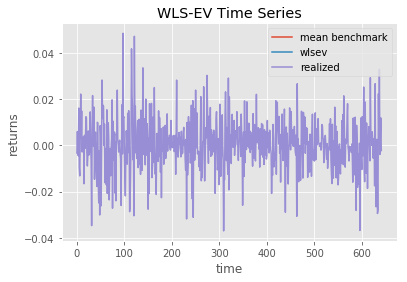

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.0001 -0.0319]
robust bse standard errors: [ 0.0003  0.0275]
t-stats: [-0.2204 -1.1599]
In sample R_squared: 0.001
Out of sample R_squared: -0.0008
-------------------------------------------------------------------------------------------------------


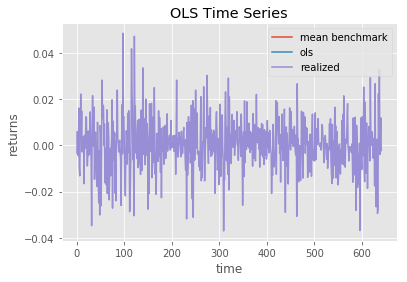

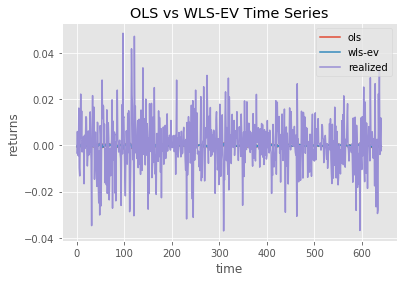

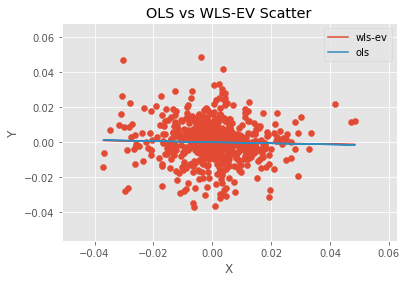

Simon's OLS Evaluation
-------------------------------------------------------------------------------------------------------
OLS betas: [[ -7.23311755e-05]
 [ -3.18528917e-02]]
OLS betas standard errors: [[ 0.00032705]
 [ 0.02752287]]
In sample R_squared: 0.001
Out of sample R_squared: -0.0006
-------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 5
-------------------------------------------------------------------------------------------------------
betas: [-0.0002 -0.0703]
robust bse standard errors: [ 0.0013  0.0495]
t-stats: [-0.1494 -1.4188]
In sample R_squared: 0.0039
Out of sample R_squared: 0.0034
-------------------------------------------------------------------------------------------------------


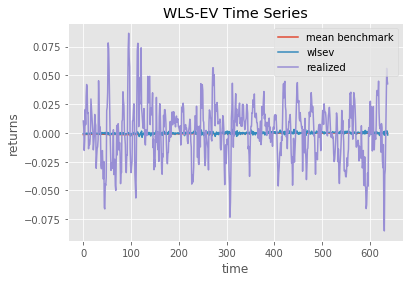

OLS Estimation Results
Forecast Horizon: 5
-------------------------------------------------------------------------------------------------------
betas: [-0.0004 -0.1582]
robust bse standard errors: [ 0.0014  0.0639]
t-stats: [-0.3011 -2.4747]
In sample R_squared: 0.0057
Out of sample R_squared: -0.0016
-------------------------------------------------------------------------------------------------------


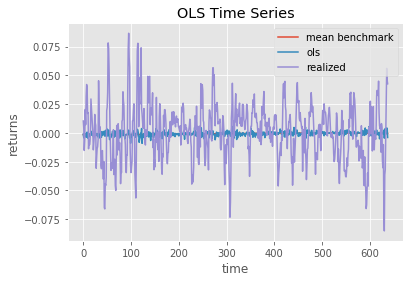

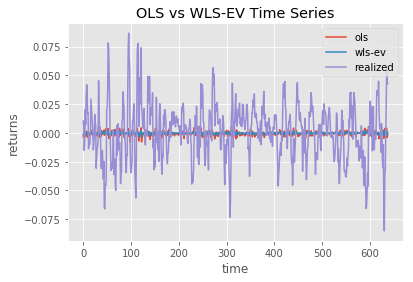

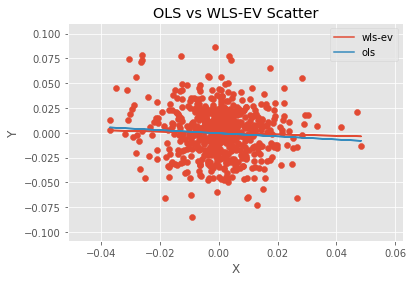

WLS-EV Estimation Results
Forecast Horizon: 10
-------------------------------------------------------------------------------------------------------
betas: [-0.0004 -0.0776]
robust bse standard errors: [ 0.0025  0.0679]
t-stats: [-0.1416 -1.142 ]
In sample R_squared: 0.0017
Out of sample R_squared: 0.0078
-------------------------------------------------------------------------------------------------------


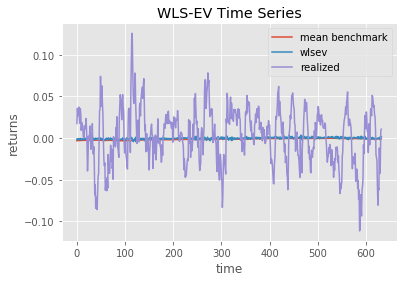

OLS Estimation Results
Forecast Horizon: 10
-------------------------------------------------------------------------------------------------------
betas: [-0.001 -0.141]
robust bse standard errors: [ 0.0023  0.088 ]
t-stats: [-0.4317 -1.6025]
In sample R_squared: 0.0024
Out of sample R_squared: -0.0018
-------------------------------------------------------------------------------------------------------


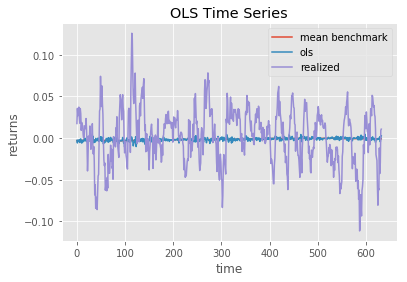

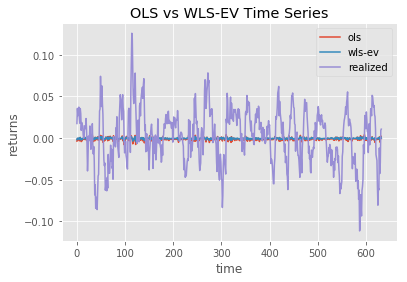

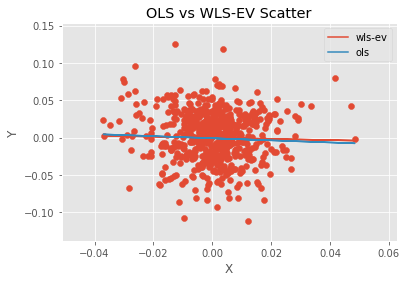

WLS-EV Estimation Results
Forecast Horizon: 50
-------------------------------------------------------------------------------------------------------
betas: [ 0.0016 -0.2672]
robust bse standard errors: [ 0.0124  0.1453]
t-stats: [ 0.1274 -1.8384]
In sample R_squared: -0.0037
Out of sample R_squared: 0.0765
-------------------------------------------------------------------------------------------------------


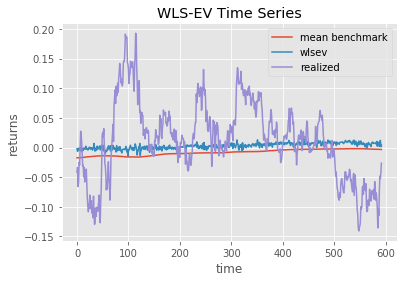

OLS Estimation Results
Forecast Horizon: 50
-------------------------------------------------------------------------------------------------------
betas: [-0.0054 -0.2801]
robust bse standard errors: [ 0.0054  0.1356]
t-stats: [-1.0029 -2.0667]
In sample R_squared: 0.0022
Out of sample R_squared: -0.0015
-------------------------------------------------------------------------------------------------------


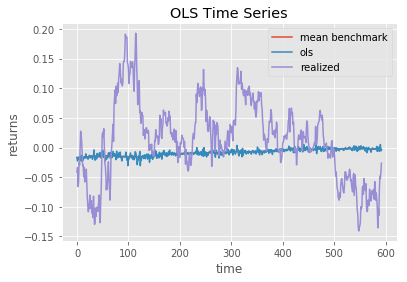

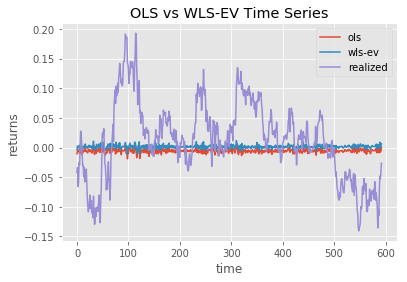

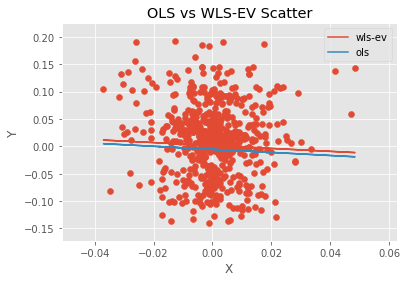

WLS-EV Estimation Results
Forecast Horizon: 100
-------------------------------------------------------------------------------------------------------
betas: [-0.0306  0.1822]
robust bse standard errors: [ 0.0266  0.2384]
t-stats: [-1.1493  0.7644]
In sample R_squared: -0.0224
Out of sample R_squared: -0.2365
-------------------------------------------------------------------------------------------------------


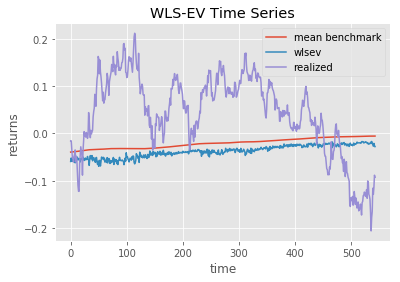

OLS Estimation Results
Forecast Horizon: 100
-------------------------------------------------------------------------------------------------------
betas: [-0.0102  0.0424]
robust bse standard errors: [ 0.0084  0.202 ]
t-stats: [-1.2116  0.2097]
In sample R_squared: 0.0
Out of sample R_squared: -0.0003
-------------------------------------------------------------------------------------------------------


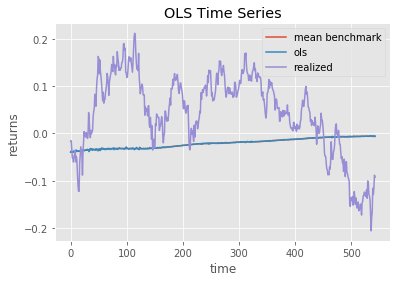

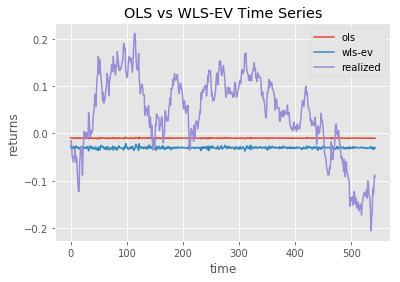

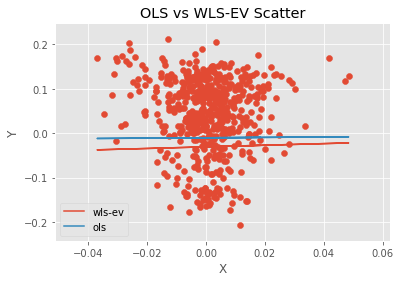

In [13]:
# 2. least squares estimates weighted by ex-ante return variance (WLS-EV) using Johnson (2016)
# ------------------------------------------------------------------------------------------------------------

for i in (1,5,10, 50, 100):
    # set forecast_horizon
    forecast_horizon = i

    # WLS-EV
    wlsev_obj = Wlsev_model(data_wop_var['logreturns'][:-1].as_matrix(), data_wop_var['logreturns'][1:].as_matrix(), data_wop_var['var_logret_daily_est'][:-1].as_matrix(), forecast_horizon)
    wlsev_obj.fit()
    # OOS evaluation to get Rsquared
    wlsev_obj.evaluate()
    wlsev_obj.print_results()
    wlsev_obj.plot_results()
    # get data
    X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

    # OLS
    ols_obj = OLS_model(data_wop_var['logreturns'][:-1].as_matrix(), data_wop_var['logreturns'][1:].as_matrix(), forecast_horizon)
    ols_obj.fit()
    # OOS evaluation to get Rsquared
    ols_obj.evaluate()
    ols_obj.print_results()
    ols_obj.plot_results()
    # get data
    X, Y, y_ols = ols_obj.get_plot_data_ols()


    # Visualisation
    # ------------------------------------------------------------------------------------------------------------

    # time series plot
    visualisation.plot_results(X,Y,y_wlsev, y_ols)
    # scatter plot
    visualisation.plot_scatter(X,Y,y_wlsev, y_ols)


    # Get Simon's OLS estimation results
    if forecast_horizon == 1:
        ols_model = OLS(data_wop_var['logreturns'][:-1].as_matrix(), data_wop_var['logreturns'][1:].as_matrix())
        ols_model.fit()
        ols_model.printResults()

### Regress ERP on VRP

##### forecast horizon several months ahead months

WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.0002 -0.0079]
robust bse standard errors: [ 0.0003  0.0134]
t-stats: [-0.8463 -0.5932]
In sample R_squared: 0.0001
Out of sample R_squared: 0.0011
-------------------------------------------------------------------------------------------------------


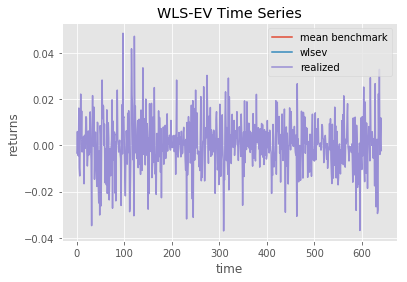

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.0002 -0.0048]
robust bse standard errors: [ 0.0004  0.0153]
t-stats: [-0.5978 -0.3137]
In sample R_squared: 0.0001
Out of sample R_squared: 0.0001
-------------------------------------------------------------------------------------------------------


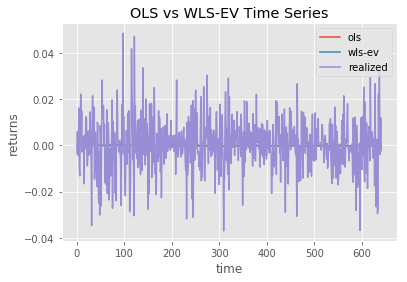

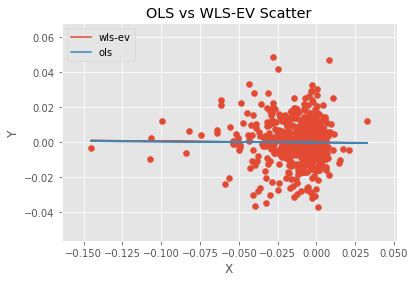

Simon's OLS Evaluation
-------------------------------------------------------------------------------------------------------
OLS betas: [[-0.00023463]
 [-0.00479207]]
OLS betas standard errors: [[ 0.00039015]
 [ 0.01548322]]
In sample R_squared: 0.0001
Out of sample R_squared: -0.0031
-------------------------------------------------------------------------------------------------------


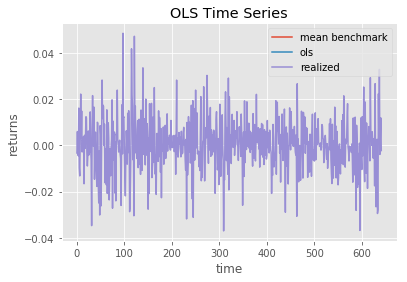

WLS-EV Estimation Results
Forecast Horizon: 22
-------------------------------------------------------------------------------------------------------
betas: [-0.0041 -0.0645]
robust bse standard errors: [ 0.003   0.1723]
t-stats: [-1.3757 -0.3747]
In sample R_squared: 0.0027
Out of sample R_squared: 0.0106
-------------------------------------------------------------------------------------------------------


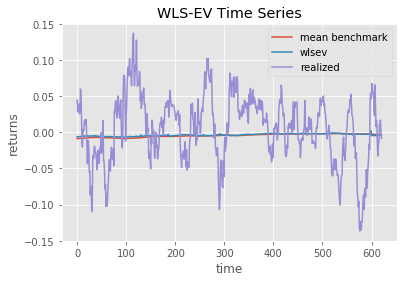

OLS Estimation Results
Forecast Horizon: 22
-------------------------------------------------------------------------------------------------------
betas: [-0.0056 -0.0982]
robust bse standard errors: [ 0.0038  0.1307]
t-stats: [-1.4669 -0.7517]
In sample R_squared: 0.0032
Out of sample R_squared: -0.0146
-------------------------------------------------------------------------------------------------------


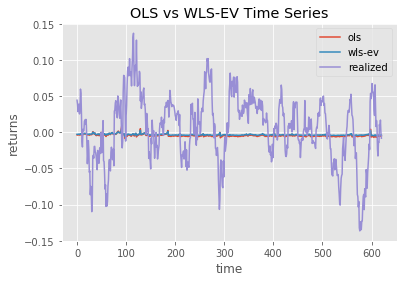

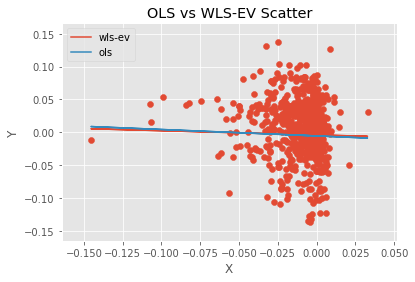

WLS-EV Estimation Results
Forecast Horizon: 44
-------------------------------------------------------------------------------------------------------
betas: [-0.0081 -0.121 ]
robust bse standard errors: [ 0.0058  0.3131]
t-stats: [-1.3907 -0.3863]
In sample R_squared: 0.0046
Out of sample R_squared: 0.0307
-------------------------------------------------------------------------------------------------------


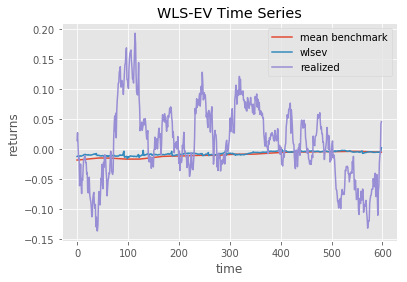

OLS Estimation Results
Forecast Horizon: 44
-------------------------------------------------------------------------------------------------------
betas: [-0.0112 -0.177 ]
robust bse standard errors: [ 0.0053  0.1408]
t-stats: [-2.1032 -1.2569]
In sample R_squared: 0.0055
Out of sample R_squared: -0.0277
-------------------------------------------------------------------------------------------------------


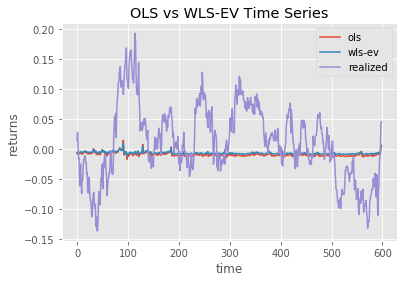

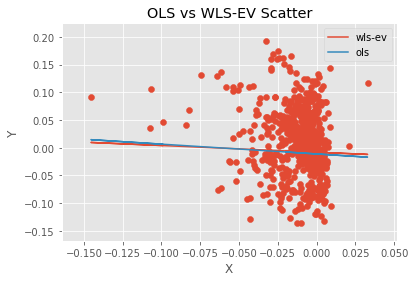

WLS-EV Estimation Results
Forecast Horizon: 66
-------------------------------------------------------------------------------------------------------
betas: [-0.0149 -0.1496]
robust bse standard errors: [ 0.0088  0.4274]
t-stats: [-1.6972 -0.3501]
In sample R_squared: 0.0048
Out of sample R_squared: 0.0137
-------------------------------------------------------------------------------------------------------


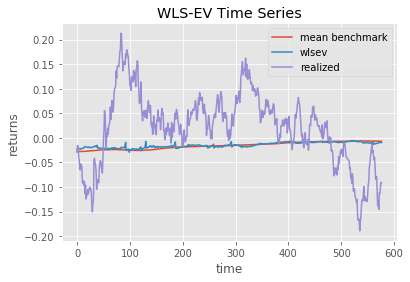

OLS Estimation Results
Forecast Horizon: 66
-------------------------------------------------------------------------------------------------------
betas: [-0.0151 -0.2007]
robust bse standard errors: [ 0.0071  0.1916]
t-stats: [-2.1327 -1.0476]
In sample R_squared: 0.0052
Out of sample R_squared: -0.0395
-------------------------------------------------------------------------------------------------------


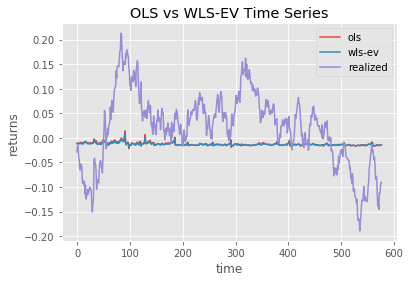

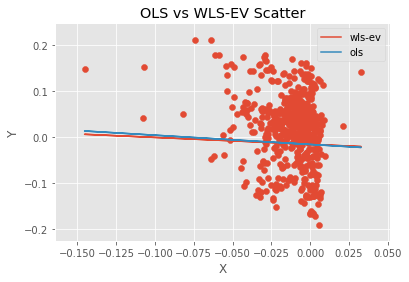

WLS-EV Estimation Results
Forecast Horizon: 88
-------------------------------------------------------------------------------------------------------
betas: [-0.0214 -0.3129]
robust bse standard errors: [ 0.0124  0.5128]
t-stats: [-1.7187 -0.6102]
In sample R_squared: 0.0118
Out of sample R_squared: 0.0324
-------------------------------------------------------------------------------------------------------


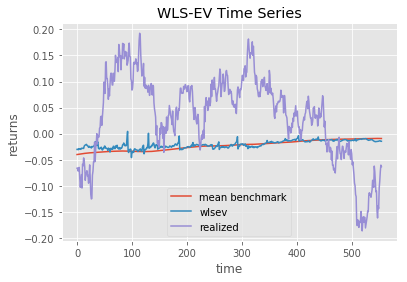

OLS Estimation Results
Forecast Horizon: 88
-------------------------------------------------------------------------------------------------------
betas: [-0.0226 -0.3697]
robust bse standard errors: [ 0.0083  0.1841]
t-stats: [-2.7236 -2.0075]
In sample R_squared: 0.0121
Out of sample R_squared: -0.0729
-------------------------------------------------------------------------------------------------------


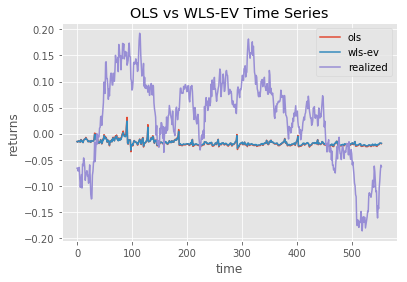

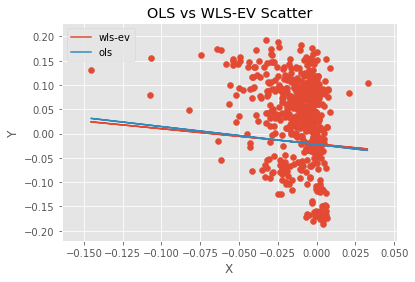

In [14]:
# set forecast_horizon
for i in (1,22,44, 66, 88):
    forecast_horizon = i

    # WLS-EV
    wlsev_obj = Wlsev_model(data_wop_var['vrp'][:-1].as_matrix(), data_wop_var['erp'][1:].as_matrix(), data_wop_var['var_logret_daily_est'][:-1].as_matrix(), forecast_horizon)
    wlsev_obj.fit()
    # OOS evaluation to get Rsquared
    wlsev_obj.evaluate()
    wlsev_obj.print_results()
    wlsev_obj.plot_results()
    # get data
    X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

    # OLS
    ols_obj = OLS_model(data_wop_var['vrp'][:-1].as_matrix(), data_wop_var['erp'][1:].as_matrix(), forecast_horizon)
    ols_obj.fit()
    # OOS evaluation to get Rsquared
    ols_obj.evaluate()
    ols_obj.print_results()
    # get data
    X, Y, y_ols = ols_obj.get_plot_data_ols()


    # Visualisation
    # ------------------------------------------------------------------------------------------------------------

    # time series plot
    visualisation.plot_results(X,Y,y_wlsev, y_ols)
    # scatter plot
    visualisation.plot_scatter(X,Y,y_wlsev, y_ols)

    # Get Simon's OLS estimation results
    if forecast_horizon == 1:
        ols_model = OLS(data_wop_var['vrp'][:-1].as_matrix(), data_wop_var['erp'][1:].as_matrix())
        ols_model.fit()
        ols_model.printResults()
        ols_obj.plot_results()

### Regress P-Moments on Q-Moments


### P_skewness_7 = f(Q_skewness_7) + error

P_skewness_7 = f(Q_skewness_7) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.1691  0.1075]
robust bse standard errors: [ 0.111   0.0768]
t-stats: [ 1.524   1.3991]
In sample R_squared: -0.0064
Out of sample R_squared: -0.0225
-------------------------------------------------------------------------------------------------------


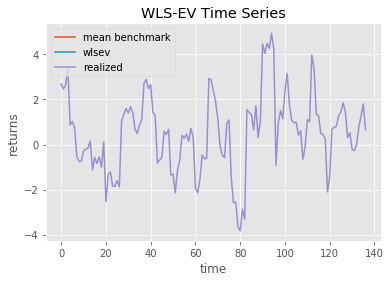

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.207   0.0395]
robust bse standard errors: [ 0.1635  0.1415]
t-stats: [ 1.2657  0.2788]
In sample R_squared: 0.0006
Out of sample R_squared: -0.0169
-------------------------------------------------------------------------------------------------------


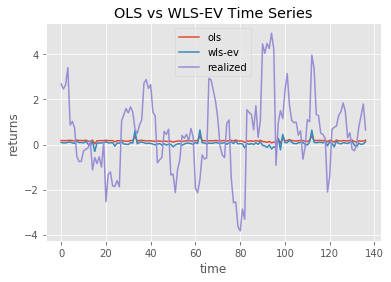

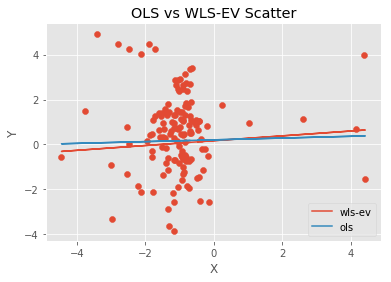

In [15]:
forecast_horizon = 1

# P_skewness_7 = f(Q_skewness_7) + error
print('P_skewness_7 = f(Q_skewness_7) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_7'][:-1].as_matrix(), data_pq_var['skewness7'][1:].as_matrix(), data_pq_var['var_est_skewness7'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_7'][:-1].as_matrix(), data_pq_var['skewness7'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# Visualisation
visualisation.plot_results(X,Y,y_wlsev, y_ols) # time series plot
visualisation.plot_scatter(X,Y,y_wlsev, y_ols) # scatter plot

### P_kurtosis_7 = f(Q_kurtosis_7) + error

P_kurtosis_7 = f(Q_kurtosis_7) + error
------------------------------------------------------------------------------------------------------------


/Users/tobias/KIT/Seminar/CRAM Seminar/CRAM_WLS-EV/wlsev_model.py:60: RuntimeWarning: invalid value encountered in sqrt
  est_var_dim_adj = self.est_var[self.forecast_horizon - 1:] ** 0.5
/Users/tobias/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1574: RuntimeWarning: invalid value encountered in greater
  return (S > tol).sum(axis=-1)


WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ nan  nan]
robust bse standard errors: [ nan  nan]
t-stats: [ nan  nan]
In sample R_squared: nan
Out of sample R_squared: nan
-------------------------------------------------------------------------------------------------------


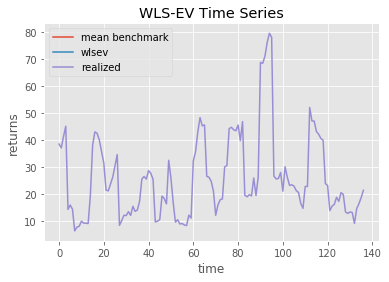

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.207   0.0395]
robust bse standard errors: [ 0.1635  0.1415]
t-stats: [ 1.2657  0.2788]
In sample R_squared: 0.0006
Out of sample R_squared: -0.0169
-------------------------------------------------------------------------------------------------------


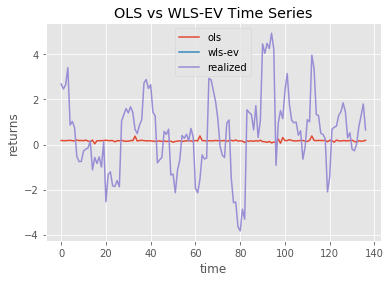

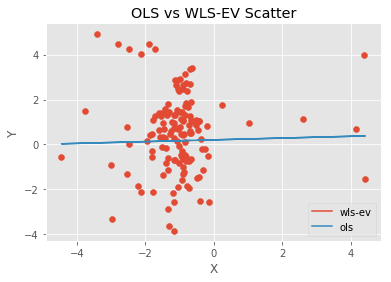

In [16]:
forecast_horizon = 1

# P_kurtosis_7 = f(Q_kurtosis_7) + error
print('P_kurtosis_7 = f(Q_kurtosis_7) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_7'][:-1].as_matrix(), data_pq_var['kurtosis7'][1:].as_matrix(), data_pq_var['var_est_kurtosis7'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_7'][:-1].as_matrix(), data_pq_var['skewness7'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# Visualisation
visualisation.plot_results(X,Y,y_wlsev, y_ols) # time series plot
visualisation.plot_scatter(X,Y,y_wlsev, y_ols) # scatter plot

### P_skewness_30 = f(Q_skewness_30) + error

P_skewness_30 = f(Q_skewness_30) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.1498  0.1833]
robust bse standard errors: [ 0.1004  0.0911]
t-stats: [ 1.4919  2.0123]
In sample R_squared: -0.0001
Out of sample R_squared: -0.0574
-------------------------------------------------------------------------------------------------------


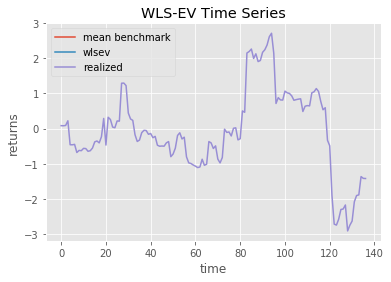

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.0651  0.0919]
robust bse standard errors: [ 0.1207  0.1283]
t-stats: [ 0.539   0.7162]
In sample R_squared: 0.0038
Out of sample R_squared: -0.0591
-------------------------------------------------------------------------------------------------------


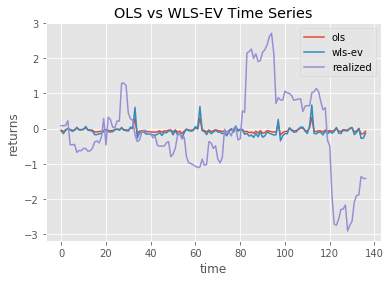

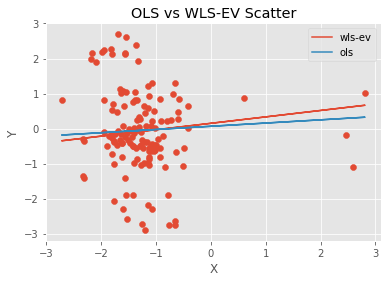

In [17]:
forecast_horizon = 1

# P_skewness_30 = f(Q_skewness_30) + error
print('P_skewness_30 = f(Q_skewness_30) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_30'][:-1].as_matrix(), data_pq_var['skewness30'][1:].as_matrix(), data_pq_var['var_est_skewness30'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_30'][:-1].as_matrix(), data_pq_var['skewness30'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# Visualisation
visualisation.plot_results(X,Y,y_wlsev, y_ols) # time series plot
visualisation.plot_scatter(X,Y,y_wlsev, y_ols) # scatter plot

### P_kurtosis_30 = f(Q_kurtosis_30) + error

P_kurtosis_30 = f(Q_kurtosis_30) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 14.7845   0.9911]
robust bse standard errors: [ 1.6571  0.3855]
t-stats: [ 8.922   2.5706]
In sample R_squared: -0.0304
Out of sample R_squared: -0.3615
-------------------------------------------------------------------------------------------------------


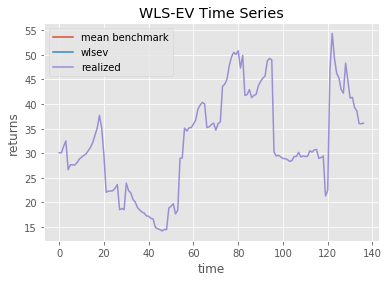

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.0651  0.0919]
robust bse standard errors: [ 0.1207  0.1283]
t-stats: [ 0.539   0.7162]
In sample R_squared: 0.0038
Out of sample R_squared: -0.0591
-------------------------------------------------------------------------------------------------------


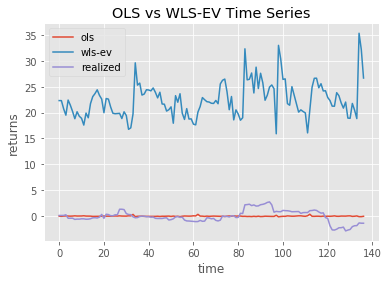

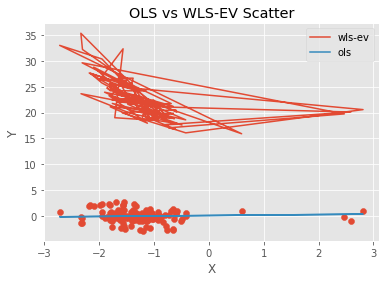

In [18]:
forecast_horizon = 1

# P_kurtosis_30 = f(Q_kurtosis_30) + error
print('P_kurtosis_30 = f(Q_kurtosis_30) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_30'][:-1].as_matrix(), data_pq_var['kurtosis30'][1:].as_matrix(), data_pq_var['var_est_kurtosis30'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_30'][:-1].as_matrix(), data_pq_var['skewness30'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# Visualisation
visualisation.plot_results(X,Y,y_wlsev, y_ols) # time series plot
visualisation.plot_scatter(X,Y,y_wlsev, y_ols) # scatter plot

### P_skewness_60 = f(Q_skewness_60) + error

P_skewness_60 = f(Q_skewness_60) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.5377  0.5087]
robust bse standard errors: [ 0.2465  0.2145]
t-stats: [ 2.1816  2.3714]
In sample R_squared: 0.0797
Out of sample R_squared: 0.1041
-------------------------------------------------------------------------------------------------------


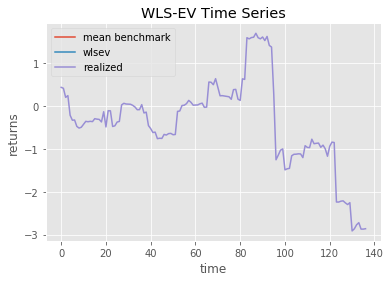

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.5857  0.5499]
robust bse standard errors: [ 0.3111  0.2682]
t-stats: [ 1.8826  2.0502]
In sample R_squared: 0.0802
Out of sample R_squared: 0.0915
-------------------------------------------------------------------------------------------------------


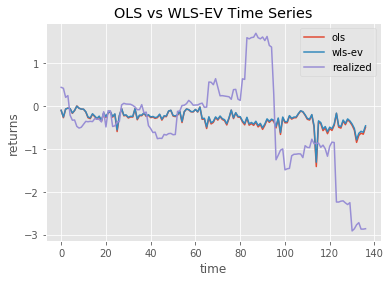

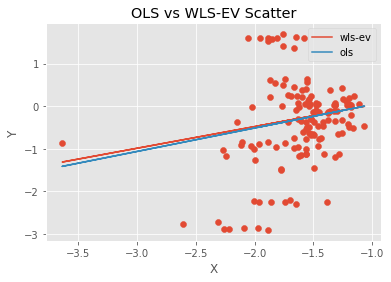

In [19]:
forecast_horizon = 1

# P_skewness_60 = f(Q_skewness_60) + error
print('P_skewness_60 = f(Q_skewness_60) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_60'][:-1].as_matrix(), data_pq_var['skewness60'][1:].as_matrix(), data_pq_var['var_est_skewness60'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_60'][:-1].as_matrix(), data_pq_var['skewness60'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# Visualisation
visualisation.plot_results(X,Y,y_wlsev, y_ols) # time series plot
visualisation.plot_scatter(X,Y,y_wlsev, y_ols) # scatter plot

### P_kurtosis_60 = f(Q_kurtosis_60) + error

P_kurtosis_60 = f(Q_kurtosis_60) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 11.7041   2.0758]
robust bse standard errors: [ 3.2991  0.5304]
t-stats: [ 3.5477  3.9135]
In sample R_squared: 0.1957
Out of sample R_squared: 0.1841
-------------------------------------------------------------------------------------------------------


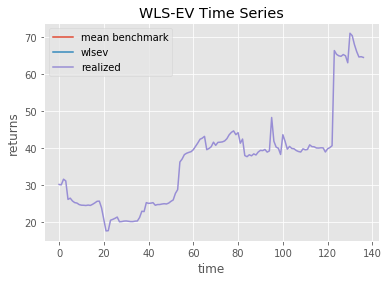

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.5857  0.5499]
robust bse standard errors: [ 0.3111  0.2682]
t-stats: [ 1.8826  2.0502]
In sample R_squared: 0.0802
Out of sample R_squared: 0.0915
-------------------------------------------------------------------------------------------------------


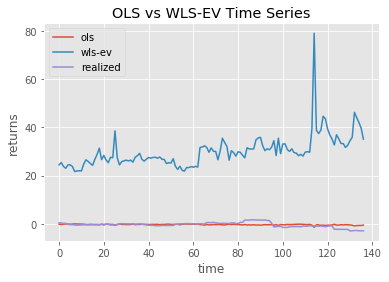

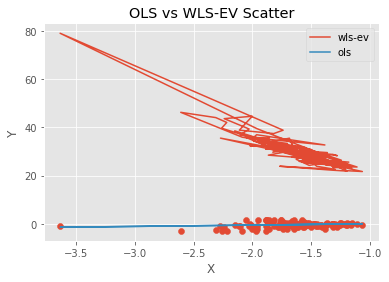

In [20]:
forecast_horizon = 1

# P_kurtosis_60 = f(Q_kurtosis_60) + error
print('P_kurtosis_60 = f(Q_kurtosis_60) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_60'][:-1].as_matrix(), data_pq_var['kurtosis60'][1:].as_matrix(), data_pq_var['var_est_kurtosis60'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_60'][:-1].as_matrix(), data_pq_var['skewness60'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# Visualisation
visualisation.plot_results(X,Y,y_wlsev, y_ols) # time series plot
visualisation.plot_scatter(X,Y,y_wlsev, y_ols) # scatter plot

### P_skewness_91 = f(Q_skewness_91) + error

P_skewness_91 = f(Q_skewness_91) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.2127  0.3564]
robust bse standard errors: [ 0.128   0.1272]
t-stats: [ 1.6614  2.8019]
In sample R_squared: 0.1336
Out of sample R_squared: 0.1131
-------------------------------------------------------------------------------------------------------


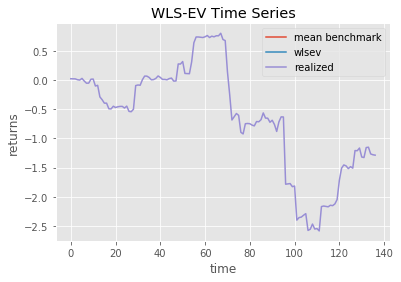

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.31    0.4784]
robust bse standard errors: [ 0.1415  0.1382]
t-stats: [ 2.1913  3.4622]
In sample R_squared: 0.1477
Out of sample R_squared: 0.1735
-------------------------------------------------------------------------------------------------------


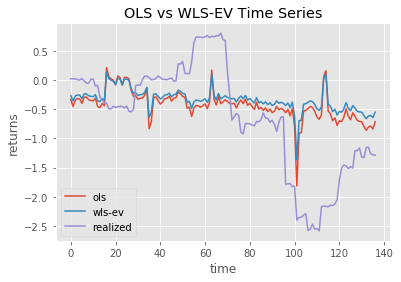

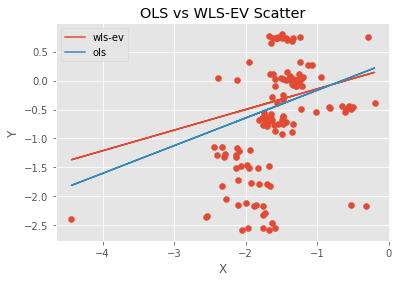

In [21]:
forecast_horizon = 1

# P_skewness_91 = f(Q_skewness_91) + error
print('P_skewness_91 = f(Q_skewness_91) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_91'][:-1].as_matrix(), data_pq_var['skewness91'][1:].as_matrix(), data_pq_var['var_est_skewness91'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_91'][:-1].as_matrix(), data_pq_var['skewness91'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# Visualisation
visualisation.plot_results(X,Y,y_wlsev, y_ols) # time series plot
visualisation.plot_scatter(X,Y,y_wlsev, y_ols) # scatter plot

### P_kurtosis_91 = f(Q_kurtosis_91) + error

P_kurtosis_91 = f(Q_kurtosis_91) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 16.8102   2.2892]
robust bse standard errors: [ 3.0478  0.5762]
t-stats: [ 5.5156  3.9726]
In sample R_squared: 0.251
Out of sample R_squared: 0.2542
-------------------------------------------------------------------------------------------------------


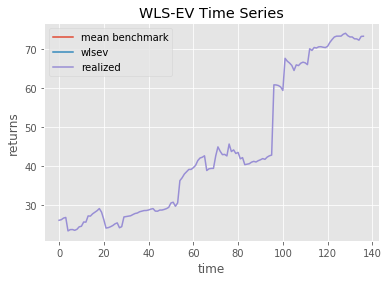

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.31    0.4784]
robust bse standard errors: [ 0.1415  0.1382]
t-stats: [ 2.1913  3.4622]
In sample R_squared: 0.1477
Out of sample R_squared: 0.1735
-------------------------------------------------------------------------------------------------------


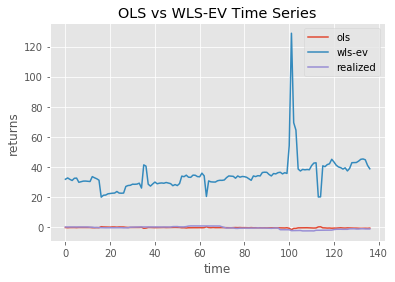

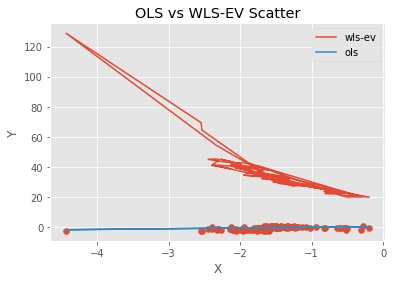

In [22]:
forecast_horizon = 1

# P_kurtosis_91 = f(Q_kurtosis_91) + error
print('P_kurtosis_91 = f(Q_kurtosis_91) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_91'][:-1].as_matrix(), data_pq_var['kurtosis91'][1:].as_matrix(), data_pq_var['var_est_kurtosis91'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_91'][:-1].as_matrix(), data_pq_var['skewness91'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# Visualisation
visualisation.plot_results(X,Y,y_wlsev, y_ols) # time series plot
visualisation.plot_scatter(X,Y,y_wlsev, y_ols) # scatter plot

### P_skewness_182 = f(Q_skewness_182) + error

P_skewness_182 = f(Q_skewness_182) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 1.5041  1.2573]
robust bse standard errors: [ 0.1551  0.1174]
t-stats: [  9.6995  10.7132]
In sample R_squared: 0.6668
Out of sample R_squared: 0.5834
-------------------------------------------------------------------------------------------------------


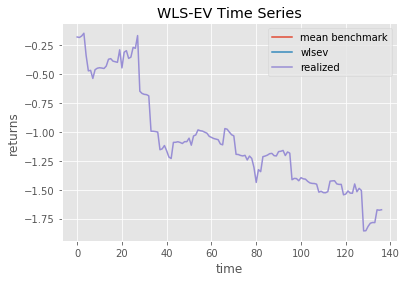

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 1.672   1.4051]
robust bse standard errors: [ 0.1238  0.0859]
t-stats: [ 13.5027  16.358 ]
In sample R_squared: 0.6788
Out of sample R_squared: 0.6868
-------------------------------------------------------------------------------------------------------


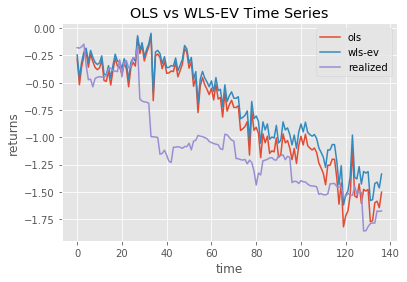

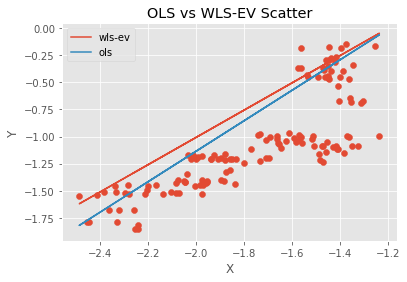

In [23]:
forecast_horizon = 1

# P_skewness_182 = f(Q_skewness_182) + error
print('P_skewness_182 = f(Q_skewness_182) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_182'][:-1].as_matrix(), data_pq_var['skewness182'][1:].as_matrix(), data_pq_var['var_est_skewness182'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_182'][:-1].as_matrix(), data_pq_var['skewness182'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# Visualisation
visualisation.plot_results(X,Y,y_wlsev, y_ols) # time series plot
visualisation.plot_scatter(X,Y,y_wlsev, y_ols) # scatter plot

### P_kurtosis_182 = f(Q_kurtosis_182) + error

P_kurtosis_182 = f(Q_kurtosis_182) + error
------------------------------------------------------------------------------------------------------------


/Users/tobias/KIT/Seminar/CRAM Seminar/CRAM_WLS-EV/wlsev_model.py:60: RuntimeWarning: invalid value encountered in sqrt
  est_var_dim_adj = self.est_var[self.forecast_horizon - 1:] ** 0.5
/Users/tobias/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1574: RuntimeWarning: invalid value encountered in greater
  return (S > tol).sum(axis=-1)


WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ nan  nan]
robust bse standard errors: [ nan  nan]
t-stats: [ nan  nan]
In sample R_squared: nan
Out of sample R_squared: nan
-------------------------------------------------------------------------------------------------------


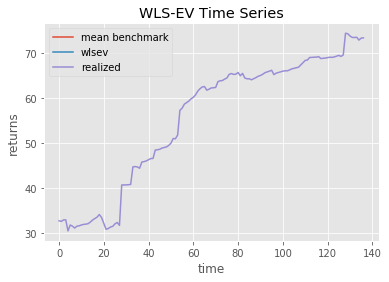

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 1.672   1.4051]
robust bse standard errors: [ 0.1238  0.0859]
t-stats: [ 13.5027  16.358 ]
In sample R_squared: 0.6788
Out of sample R_squared: 0.6868
-------------------------------------------------------------------------------------------------------


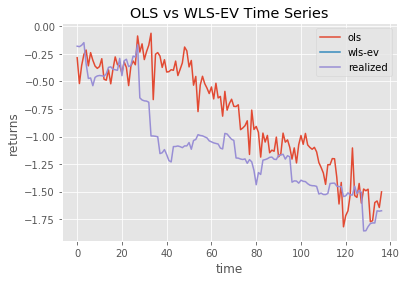

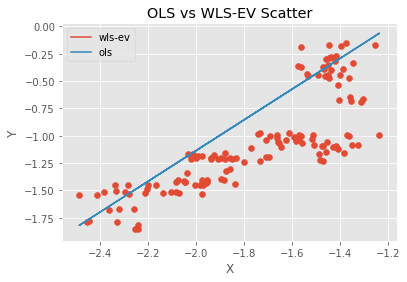

In [24]:
forecast_horizon = 1

# P_kurtosis_182 = f(Q_kurtosis_182) + error
print('P_kurtosis_182 = f(Q_kurtosis_182) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_182'][:-1].as_matrix(), data_pq_var['kurtosis182'][1:].as_matrix(), data_pq_var['var_est_kurtosis7'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_182'][:-1].as_matrix(), data_pq_var['skewness182'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# Visualisation
visualisation.plot_results(X,Y,y_wlsev, y_ols) # time series plot
visualisation.plot_scatter(X,Y,y_wlsev, y_ols) # scatter plot

### P_skewness_365 = f(Q_skewness_365) + error

P_skewness_365 = f(Q_skewness_365) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.5843  0.7503]
robust bse standard errors: [ 0.2178  0.1697]
t-stats: [ 2.6831  4.4224]
In sample R_squared: 0.551
Out of sample R_squared: 0.4752
-------------------------------------------------------------------------------------------------------


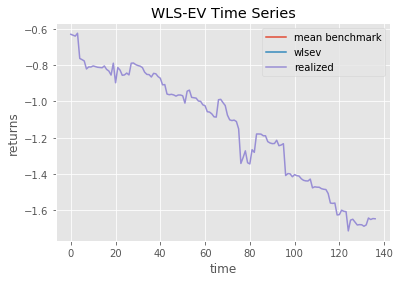

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.6524  0.8422]
robust bse standard errors: [ 0.2015  0.1487]
t-stats: [ 3.238   5.6633]
In sample R_squared: 0.5664
Out of sample R_squared: 0.6158
-------------------------------------------------------------------------------------------------------


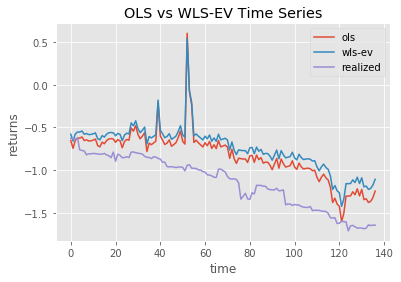

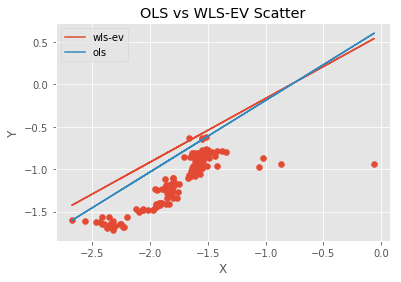

In [25]:
forecast_horizon = 1

# P_skewness_365 = f(Q_skewness_365) + error
print('P_skewness_365 = f(Q_skewness_365) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_365'][:-1].as_matrix(), data_pq_var['skewness365'][1:].as_matrix(), data_pq_var['var_est_skewness365'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_365'][:-1].as_matrix(), data_pq_var['skewness365'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# Visualisation
visualisation.plot_results(X,Y,y_wlsev, y_ols) # time series plot
visualisation.plot_scatter(X,Y,y_wlsev, y_ols) # scatter plot

### P_kurtosis_365 = f(Q_kurtosis_365) + error

P_kurtosis_365 = f(Q_kurtosis_365) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 12.9892   6.354 ]
robust bse standard errors: [ 2.8968  0.5762]
t-stats: [  4.4839  11.0272]
In sample R_squared: 0.6336
Out of sample R_squared: 0.6263
-------------------------------------------------------------------------------------------------------


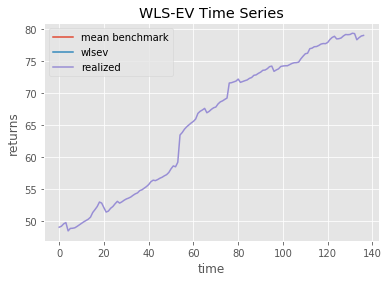

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.6524  0.8422]
robust bse standard errors: [ 0.2015  0.1487]
t-stats: [ 3.238   5.6633]
In sample R_squared: 0.5664
Out of sample R_squared: 0.6158
-------------------------------------------------------------------------------------------------------


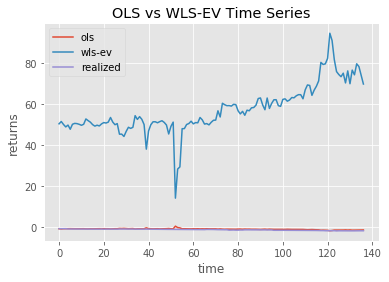

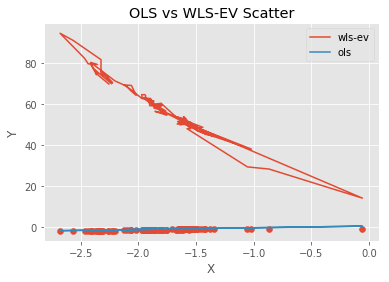

In [26]:
forecast_horizon = 1

# P_kurtosis_365 = f(Q_kurtosis_365) + error
print('P_kurtosis_365 = f(Q_kurtosis_365) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_365'][:-1].as_matrix(), data_pq_var['kurtosis365'][1:].as_matrix(), data_pq_var['var_est_kurtosis365'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_365'][:-1].as_matrix(), data_pq_var['skewness365'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# Visualisation
visualisation.plot_results(X,Y,y_wlsev, y_ols) # time series plot
visualisation.plot_scatter(X,Y,y_wlsev, y_ols) # scatter plot

### Regress Fama French Factors on Q-Moment